# Deep Learning - Previsão de Séries Temporais com LSTM

## Objetivo
O objetivo deste notebook é construir, treinar e avaliar um modelo de Redes Neurais Recorrentes do tipo **LSTM (_Long Short-Term Memory_)** para prever os preços de fechamento das ações da **Microsoft (MSFT)**. Diferente dos modelos estatísticos lineares (como o ARIMA), buscaremos capturar padrões complexos e dependências de longo prazo na série temporal.

## Ativo de Estudo
* **Ticker:** MSFT (Microsoft Corporation)
* **Fonte:** Dataset Big Tech Giants / Yahoo Finance
* **Métrica Principal:** Preço de Fechamento (Close)

## Pipeline de Desenvolvimento
1. **Preparação de Dados:** Seleção do ativo e limpeza.
2. **Normalização:** Escalonamento dos dados entre 0 e 1 (MinMaxScaler).
3. **Criação da Janela de Memória:** Estruturação dos dados em sequências temporais (Lookback Period).
4. **Arquitetura da Rede:** Definição das camadas LSTM, Dropout e Dense.
5. **Treinamento e Validação:** Monitoramento da perda (Loss) e ajuste de hiperparâmetros.
6. **Avaliação e Previsão:** Comparação entre valores reais e previstos com métricas de erro (RMSE/MAE).

### 1. Importação e Pré-processamento
Nesta etapa, filtramos os dados históricos da Microsoft e aplicamos a normalização Min-Max. O escalonamento é vital para redes neurais, pois acelera a convergência do gradiente e evita que valores de preços altos (ex: $300) causem instabilidade numérica nos pesos da rede.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/big_tech_stock_prices.csv')
df.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
0,AAPL,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,AAPL,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,AAPL,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,AAPL,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,AAPL,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [3]:
# Selecionando dados da Microsoft
df_msft = df[df['stock_symbol'] == 'MSFT'].copy()
df_msft.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
28856,MSFT,2010-01-04,30.620001,31.100000,30.590000,30.950001,23.683071,38409100
28857,MSFT,2010-01-05,30.850000,31.100000,30.639999,30.959999,23.690725,49749600
28858,MSFT,2010-01-06,30.879999,31.080000,30.520000,30.770000,23.545338,58182400
28859,MSFT,2010-01-07,30.629999,30.700001,30.190001,30.450001,23.300467,50559700
28860,MSFT,2010-01-08,30.280001,30.879999,30.240000,30.660000,23.461161,51197400


In [4]:
# Isolando a variável alvo (preço de fechamento)
target = df_msft['close'].values.reshape(-1,1)
target.shape

(3271, 1)

In [5]:
# Aplicando o MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
target_scaled = scaler.fit_transform(target)
target_scaled.shape

(3271, 1)

### 2. Estruturação dos Dados (Janelas Temporais)
O LSTM precisa receber os dados em um formato de "supervisionado". Criaremos janelas de **60 dias (_lookback_)**:
* **X (Inputs):** Sequências contendo os preços dos últimos 60 dias.
* **y (Target):** O preço do dia seguinte (61º dia).

Este processo transforma a série única em um conjunto de amostras que a rede usará para aprender a relação entre o passado recente e o futuro imediato.

In [6]:
# Definindo o tamanho da janela
window_size = 60

X = []
y = []

for i in range(window_size, len(target_scaled)):
    X.append(target_scaled[i-window_size:i, 0])
    y.append(target_scaled[i,0])

# Convertendo para arrays numpy
X, y = np.array(X), np.array(y)

print("Formato de X:", X.shape)

Formato de X: (3211, 60)


In [7]:
# Reshape de X para (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print("Novo formato de X:", X.shape)

Novo formato de X: (3211, 60, 1)


In [8]:
# Separando em treino e teste

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Tamanho de X_train:", len(X_train))
print("Tamanho de X_test:", len(X_test))

Tamanho de X_train: 2568
Tamanho de X_test: 643


### 3. Construção e Treinamento do Modelo LSTM
Nesta etapa, definimos a arquitetura da rede neural. Utilizaremos uma **Stacked LSTM** com as seguintes características:
* **Camadas LSTM:** Responsáveis por aprender as dependências temporais.
* **Dropout:** Camadas de regularização que "desligam" neurônios aleatoriamente para evitar o *_overfitting_*.
* **Dense Layer:** Uma camada de saída que consolida o aprendizado em um único valor (o preço previsto).
* **Optimizer (Adam):** Algoritmo de otimização eficiente para ajustar os pesos da rede.

In [ ]:
# Configurando reprodutibilidade
from tensorflow.random import set_seed
import random
import os


def set_reproducibility(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    set_seed(seed)
    # Garante operações determinísticas no TensorFlow (se possível na CPU/GPU)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Semente {seed} aplicada para reprodutibilidade.")

set_reproducibility(42)

Semente 42 aplicada para reprodutibilidade.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Construindo o modelo LSTM
model = Sequential()

# Primeira camada LSTM com Dropout
model.add(Input(shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Segunda camada LSTM com Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída
model.add(Dense(units=1))

# Compilação
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Definindo o early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinando o modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0022 - val_loss: 8.9946e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.6735e-04 - val_loss: 9.2885e-04
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.7377e-04 - val_loss: 9.2771e-04
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.1180e-04 - val_loss: 9.5708e-04
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.9509e-04 - val_loss: 0.0012
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.6838e-04 - val_loss: 0.0011
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.7564e-04 - val_loss: 0.0023
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.8607e-04 - val_loss: 0.0030
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.6096e-04 - val_loss: 0.0043
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.2731e-04 - val_loss: 8.0177e-04
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.4160e-04 - val_loss:

## 5. Avaliação de Desempenho e Previsões
Nesta etapa, utilizamos o modelo treinado para prever os preços no conjunto de teste. 
Como os dados estão normalizados, realizaremos a **Inversão da Escala** para retornar os valores aos preços originais em dólares. 
A métrica principal de avaliação será o **RMSE (Root Mean Squared Error)**, que nos indica a magnitude média do erro das previsões.

In [12]:
from sklearn.metrics import mean_squared_error

# Fazendo previsões
y_pred_scaled = model.predict(X_test)

# Invertendo a escala das previsões
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
print(f"RMSE do modelo LSTM: {rmse:.2f} USD")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
RMSE do modelo LSTM: 6.58 USD


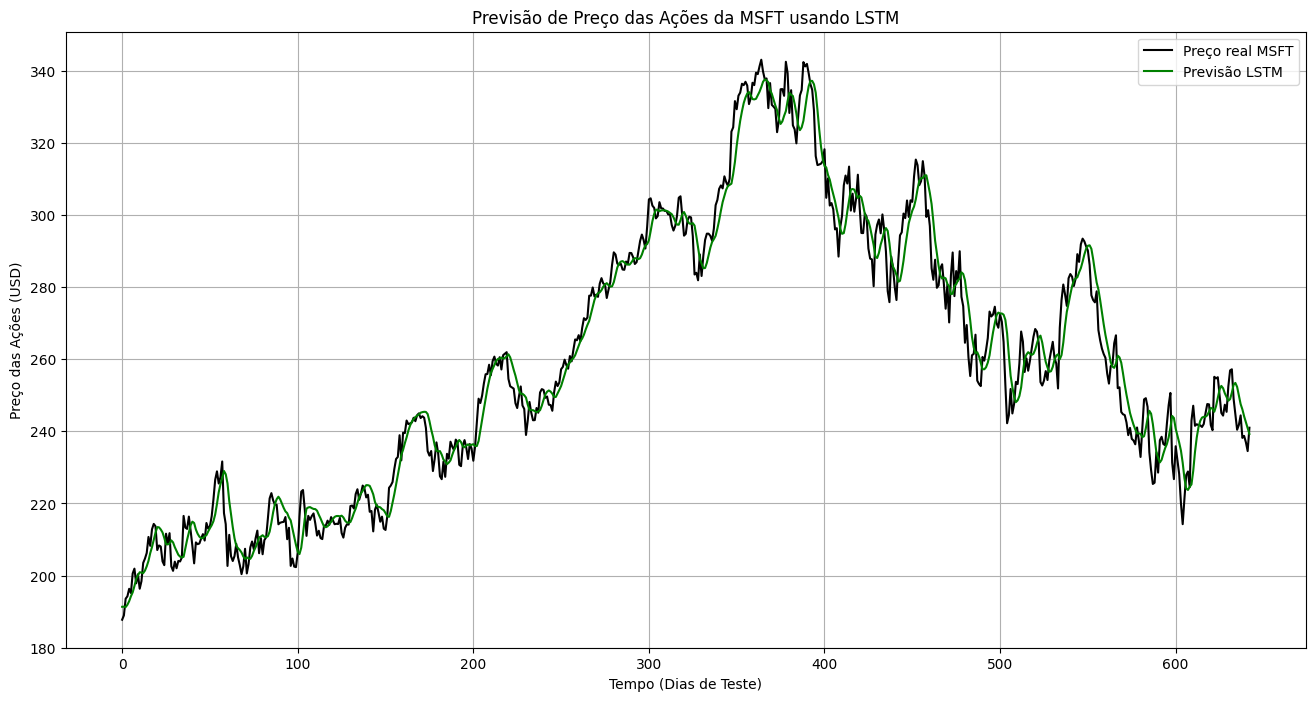

In [13]:
# Plotando os resultados

plt.figure(figsize=(16,8))
plt.plot(y_test_real, color='black', label='Preço real MSFT')
plt.plot(y_pred, color='green', label='Previsão LSTM')
plt.title('Previsão de Preço das Ações da MSFT usando LSTM')
plt.xlabel('Tempo (Dias de Teste)')
plt.ylabel('Preço das Ações (USD)')
plt.grid()
plt.legend()
plt.show()

### 6. Análise de Resultados e Conclusões

#### Performance do Modelo
* **RMSE (Root Mean Squared Error):** 6.58 USD.
* **Aderência:** O gráfico demonstra que a rede LSTM conseguiu acompanhar as principais tendências de alta e baixa do ativo. 
* **Efeito de Lag (Atraso):** Como esperado em modelos de séries temporais, observa-se um leve atraso nas previsões em momentos de reversão brusca de tendência. Isso ocorre porque o modelo baseia sua decisão nos 60 dias anteriores.

#### Insights Técnicos
1. **Captura de Volatilidade:** O modelo não apenas seguiu a média, mas tentou mapear os picos e vales, o que indica que as camadas de Dropout ajudaram na generalização sem causar um suavização excessiva (underfitting).
2. **Estabilidade:** A convergência da perda durante o treinamento refletiu-se em previsões estáveis no conjunto de teste, sem ruídos aleatórios extremos.

Vamos finalizar o notebook salvando o modelo.

In [14]:
import joblib

# Salvando o modelo treinado e o scaler

model.save('../models/msft_lstm_model_v1.keras')
print("Modelo salvo com sucesso!")

joblib.dump(scaler, '../models/msft_scaler.pkl')
print("Scaler salvo com sucesso!")

Modelo salvo com sucesso!
Scaler salvo com sucesso!


### 7. Engenharia de Atributos (Multivariado)
Nesta etapa, enriquecemos o dataset com indicadores técnicos para fornecer mais contexto à rede neural. As novas features são:
1. **Médias Móveis (7 e 21 dias):** Capturam tendências de curto e médio prazo, suavizando ruídos.
2. **Volume:** Indica a força por trás dos movimentos de preço.
3. **Retorno Diário:** Ajuda o modelo a entender a volatilidade e variações percentuais.

In [15]:
# Criando uma cópia do dataframe
df_msft = df[df['stock_symbol'] == 'MSFT'].copy()
df_msft = df_msft.sort_values('date')

# Encontrando as médias móveis
df_msft['MA7'] = df_msft['close'].rolling(window=7).mean()
df_msft['MA21'] = df_msft['close'].rolling(window=21).mean()

# Retornos diários
df_msft['daily_return'] = df_msft['close'].pct_change()

# Removendo valores NaN
df_msft.dropna(inplace=True)

# Colunas a serem utilizadas como entradas
features_cols = ['close', 'MA7', 'MA21', 'daily_return', 'volume']
data_multivariate = df_msft[features_cols].values

print("Formato dos dados multivariados:", data_multivariate.shape)


Formato dos dados multivariados: (3251, 5)


In [16]:
# Aplicando o MinMaxScaler
scaler_multi = MinMaxScaler(feature_range=(0,1))
data_multivariate_scaled = scaler_multi.fit_transform(data_multivariate)
data_multivariate_scaled.shape

(3251, 5)

In [17]:
# Redefinindo o tamanho da janela
window_size = 60
X_multi = []
y_multi = []

for i in range(window_size, len(data_multivariate_scaled)):
    X_multi.append(data_multivariate_scaled[i-window_size:i])
    y_multi.append(data_multivariate_scaled[i,0])

# Convertendo para arrays numpy
X_multi, y_multi = np.array(X_multi), np.array(y_multi)
print("Formato de X_multi:", X_multi.shape)

Formato de X_multi: (3191, 60, 5)


### 8. Preparação do Modelo Multivariado
Com a inclusão de novas features, o modelo agora recebe uma matriz tridimensional com 5 variáveis de entrada. 
A arquitetura LSTM será ajustada para reconhecer essa nova profundidade de dados, mantendo a capacidade de prever o valor escalar do preço de fechamento futuro.

In [18]:
# Separando em treino e teste
train_size = int(len(X_multi)*0.8)

X_train_multi, X_test_multi = X_multi[:train_size], X_multi[train_size:]
y_train_multi, y_test_multi = y_multi[:train_size], y_multi[train_size:]

print(f"Treino: {X_train_multi.shape}, Teste: {X_test_multi.shape}")

Treino: (2552, 60, 5), Teste: (639, 60, 5)


In [21]:
# Construindo o modelo LSTM para dados multivariados
model_m = Sequential()

# Primeira camada
model_m.add(Input(shape=(X_train_multi.shape[1], X_train_multi.shape[2])))
model_m.add(LSTM(units=50, return_sequences=True))
model_m.add(Dropout(0.2))

# Segunda camada
model_m.add(LSTM(units=50, return_sequences=False))
model_m.add(Dropout(0.2))

# Camada de saída
model_m.add(Dense(units=1))

# Compilação
model_m.compile(optimizer='adam', loss='mean_squared_error')

model_m.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Treinando o modelo para dados multivariados
# O early stopping já foi definido anteriormente

history_multi = model_m.fit(
    X_train_multi, y_train_multi,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_multi, y_test_multi),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.3901e-04 - val_loss: 0.0027
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.3044e-04 - val_loss: 0.0018
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.8349e-04 - val_loss: 0.0017
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.3809e-04 - val_loss: 0.0012
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.1589e-04 - val_loss: 0.0017
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.1098e-04 - val_loss: 0.0014
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.5779e-04 - val_loss: 0.0014
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.0692e-04 - val_loss: 0.0018
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7274e-04 - val_loss: 0.0034


### 9. Comparação: Univariado vs. Multivariado
A introdução de indicadores técnicos (MA7, MA21, Volume e Retornos) alterou a dinâmica de aprendizado:
* **Ponto Positivo:** A perda de validação inicial foi menor, indicando que os indicadores técnicos ajudam a rede a se situar melhor no início do treino.
* **Observação:** A convergência final foi similar ao modelo anterior, sugerindo que apenas adicionar dados pode não ser suficiente sem uma otimização da arquitetura (hiperparâmetros) para lidar com a complexidade extra.

### 10. Avaliação do Modelo Multivariado
Para avaliar o erro em dólares, realizamos a inversão da escala. Como o `scaler` foi treinado com 5 colunas, criamos um array auxiliar para recompor o formato original antes da transformação inversa, garantindo que o erro seja calculado apenas sobre o preço de fechamento.

In [ ]:
# Fazendo as previsões
y_pred_multi_scaled = model_m.predict(X_test_multi)

# Criando um array vazio com o formato (samples, features)
train_predict_dataset = np.zeros(shape=(len(y_pred_multi_scaled), 5))

# Substituindo a primeira coluna pelo y_pred_multi_scaled
train_predict_dataset[:,0] = y_pred_multi_scaled[:,0]

# Invertendo a escala
y_pred_multi = scaler_multi.inverse_transform(train_predict_dataset)[:,0]

# Invertendo a escala do y_test_multi (dados reais)
test_real_dataset = np.zeros(shape=(len(y_test_multi), 5))
test_real_dataset[:,0] = y_test_multi
y_test_multi_real = scaler_multi.inverse_transform(test_real_dataset)[:,0]

# Calculando o RMSE
rmse_multi = np.sqrt(mean_squared_error(y_test_multi_real, y_pred_multi))

print(f"RMSE do modelo LSTM univariado: {rmse:.2f} USD")
print(f"RMSE do modelo LSTM multivariado: {rmse_multi:.2f} USD")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE do modelo LSTM univariado: 6.58 USD
RMSE do modelo LSTM multivariado: 13.65 USD


### 11. Análise Crítica: O Paradoxo Multivariado
Surpreendentemente, o modelo multivariado apresentou um RMSE de **13.65 USD**, superior aos **6.58 USD** do modelo simples. 
Este fenômeno sugere que:
1. **Ruído vs. Sinal:** As novas variáveis podem estar inserindo ruído que confunde a rede na ausência de um ajuste fino de hiperparâmetros.
2. **Capacidade da Rede:** A arquitetura atual pode ser insuficiente para processar a complexidade de 5 dimensões temporais simultâneas.

### 12. Refinamento de Features (Feature Selection)
Após observar que o modelo com 5 variáveis aumentou o erro, aplicamos uma estratégia de seleção de atributos. 
Removemos o **Volume** e o **Daily Return**, que apresentam alta volatilidade (ruído), e mantivemos as **Médias Móveis**, que atuam como guias de tendência. 
O objetivo é simplificar o aprendizado da rede sem perder o contexto histórico.

In [24]:
# Selecionando apenas as colunas de tendência
features_refined = ['close', 'MA7', 'MA21']
data_refined = df_msft[features_refined].values

# Normalização
scaler_refined = MinMaxScaler(feature_range=(0,1))
data_refined_scaled = scaler_refined.fit_transform(data_refined)

# Recriando as janelas
X_refined, y_refined = [], []
for i in range(window_size, len(data_refined_scaled)):
    X_refined.append(data_refined_scaled[i-window_size:i])
    y_refined.append(data_refined_scaled[i,0])

X_refined, y_refined = np.array(X_refined), np.array(y_refined)

# Separando em treino e teste
train_size = int(len(X_refined)*0.8)
X_train_refined, X_test_refined = X_refined[:train_size], X_refined[train_size:]
y_train_refined, y_test_refined = y_refined[:train_size], y_refined[train_size:]

print(f"Treino: {X_train_refined.shape}, Teste: {X_test_refined.shape}")

Treino: (2552, 60, 3), Teste: (639, 60, 3)


In [25]:
# Construindo o modelo LSTM para dados refinados
model_m2 = Sequential()

# Primeira camada
model_m2.add(Input(shape=(X_train_refined.shape[1], X_train_refined.shape[2])))
model_m2.add(LSTM(units=50, return_sequences=True))
model_m2.add(Dropout(0.2))

# Segunda camada
model_m2.add(LSTM(units=50, return_sequences=False))
model_m2.add(Dropout(0.2))

# Camada de saída
model_m2.add(Dense(units=1))

# Compilação
model_m2.compile(optimizer='adam', loss='mean_squared_error')

model_m2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Treinando o modelo para dados multivariados refinados

history_refined = model_m2.fit(
    X_train_refined, y_train_refined,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_refined, y_test_refined),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.9232e-04 - val_loss: 0.0013
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.7852e-04 - val_loss: 0.0017
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.4754e-04 - val_loss: 0.0011
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.1588e-04 - val_loss: 0.0011
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.0499e-04 - val_loss: 0.0017
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.6865e-04 - val_loss: 0.0015
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8749e-04 - val_loss: 0.0023
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.7667e-04 - val_loss: 0.0015
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.5802e-04 - val_loss: 0.0016


In [27]:
# Fazendo as previsões
y_pred_refined_scaled = model_m2.predict(X_test_refined)

# Criando um array vazio com o formato (samples, features)
dataset_refined = np.zeros(shape=(len(y_pred_refined_scaled), 3))
dataset_refined[:,0] = y_pred_refined_scaled[:,0]

# Invertendo a escala
y_pred_refined = scaler_refined.inverse_transform(dataset_refined)[:,0]

# Invertendo a escala do y_test_refined
test_real_dataset = np.zeros(shape=(len(y_test_refined), 3))
test_real_dataset[:,0] = y_test_refined
y_test_refined_real = scaler_refined.inverse_transform(test_real_dataset)[:,0]

# Calculando o RMSE
rmse_refined = np.sqrt(mean_squared_error(y_test_refined_real, y_pred_refined))

print(f"RMSE do modelo LSTM univariado: {rmse:.2f} USD")
print(f"RMSE do modelo LSTM multivariado: {rmse_multi:.2f} USD")
print(f"RMSE do modelo LSTM multivariado refinado: {rmse_refined:.2f} USD")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
RMSE do modelo LSTM univariado: 6.58 USD
RMSE do modelo LSTM multivariado: 13.65 USD
RMSE do modelo LSTM multivariado refinado: 13.38 USD


### 13. Veredito da Engenharia de Atributos
O experimento com variáveis multivariadas trouxe os seguintes aprendizados:
1. **Univariado (Baseline):** 6.58 USD.
2. **Multivariado (5 vars):** 13.65 USD.
3. **Multivariado Refinado (3 vars):** 13.38 USD.

**Conclusão:** A adição de indicadores técnicos sem uma otimização da arquitetura da rede não superou a simplicidade do modelo focado apenas no preço. Isso indica que a próxima etapa fundamental é o **Otimização de Hiperparâmetros**, para ajustar a capacidade da rede a lidar com as novas dimensões de dados.